In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

from tqdm import tqdm
from multiprocessing import Pool
from datetime import datetime, timedelta, date

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [6]:
#importing datasets
projects = pd.read_csv(r'data/all_projects_data.csv')
hacks = pd.read_csv(r'data/hacks_data.csv')
participants = pd.read_csv(r'data/participants.csv')
participants_locations = pd.read_csv(r'data/all_locations_cleaned.csv')

participants_locations = participants_locations[['country', 'lat', 'lon']] #from whole table we are interested only in country, lat and lon

#deleting duplicates
projects.drop_duplicates(inplace=True)
hacks.drop_duplicates(inplace=True)
participants.drop_duplicates(inplace=True)
participants_locations.drop_duplicates(inplace=True)


hacks = hacks.rename(columns={"submission_gallery_url": "submission_gal_url"}, errors="raise") 
hacks = hacks[~hacks['submission_gal_url'].isnull()]
hacks.submission_gal_url = hacks.submission_gal_url.astype(str)
projects.submission_gal_url = projects.submission_gal_url.astype(str)

In [7]:
hacks['start_date_format'] = pd.to_datetime(hacks['start_date_format'])
hacks['end_date_format'] = pd.to_datetime(hacks['end_date_format'])
hacks['year'] = hacks['start_date_format'].dt.year
hacks['hack_duration'] = (hacks['end_date_format'] - hacks['start_date_format']).dt.days

In [8]:
hacks.loc[hacks['Location'] != 'Online', 'Location'] = 'Offline' 

In [9]:
participants = participants[participants['country'] != 'Nan']
participants['country'].replace({'J & K': 'India', "Ari'el": 'Israel'}, inplace=True)

In [10]:
hacks = hacks[hacks['hack_duration']<21] #we deleted all hacks that last more than 21 day
hacks = hacks[hacks['hack_duration']>=0] #we also deleted hacks that last less than 0 days, becasue it simply means that start and end date were not correct

In [11]:
projects = projects.merge(hacks, on='submission_gal_url', how='left')

In [12]:
projects

,submission_gal_url,project_URL,github_links,participants,participants_num,build_with,repo_link,repo,submitted_to_link,submitted_to_name,...,end_date,year,themes,prize,registered_N,featured,organization_name,winners_announced,start_a_submission_url,hack_duration
0,https://azure-sentinel-hackathon-2021.devpost....,https://devpost.com/software/discordsecure,https://github.com/bhavanat12/SentinelHackatho...,"https://devpost.com/abhishekr272000, https://d...",3,"azure, blob, defender, discordpy, kql, mysql, ...",https://github.com/bhavanat12/SentinelHackatho...,github.com,https://azure-sentinel-hackathon-2021.devpost....,Azure Sentinel Hackathon 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://azure-sentinel-hackathon-2021.devpost....,https://devpost.com/software/migration-assist-...,https://github.com/Keshav1308/Migration-Assist...,https://devpost.com/KeshavJain,1,kql,https://github.com/Keshav1308/Migration-Assist,github.com,https://azure-sentinel-hackathon-2021.devpost....,Azure Sentinel Hackathon 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://azure-sentinel-hackathon-2021.devpost....,https://devpost.com/software/mitigating-threat...,https://github.com/varonissoc/CiscoUmbrellaSus...,"https://devpost.com/hannahannah1, https://devp...",5,"analytic-rule, apis, playbook, sentinel, teams...",https://github.com/varonissoc/CiscoUmbrellaSus...,github.com,https://azure-sentinel-hackathon-2021.devpost....,Azure Sentinel Hackathon 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://azure-sentinel-hackathon-2021.devpost....,https://devpost.com/software/teams-bot-for-azu...,https://github.com/thecollectiveconsulting/Oll...,"https://devpost.com/OLVA1993, https://devpost....",3,"adaptivecards, api, azuresentinel, bot, c#, no...",https://github.com/thecollectiveconsulting/Oll...,github.com,https://azure-sentinel-hackathon-2021.devpost....,Azure Sentinel Hackathon 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://azure-sentinel-hackathon-2021.devpost....,https://devpost.com/software/sociothreatsight,NaN,https://devpost.com/ganeshn-4488,1,"azure, natural-language-processing, python","https://sociothreatinsights.herokuapp.com/, ht...","sociothreatinsights.herokuapp.com, sociothreat...",https://azure-sentinel-hackathon-2021.devpost....,Azure Sentinel Hackathon 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173036,https://bay-area-hacks-2021-12377.devpost.com/...,https://devpost.com/software/green-karma-n5lybx,https://github.com/AravTewari/Green-Karma,https://devpost.com/aravtewari,1,"firebase, flutter",https://github.com/AravTewari/Green-Karma,github.com,https://bay-area-hacks-2021-12377.devpost.com/,Bay Area Hacks 2021,...,Mar 28,2021.0,"Enterprise, Open Ended, Productivity","$19,000",2.0,False,Ladislao,True,https://bay-area-hacks-2021-12377.devpost.com/...,0.0
173037,https://checkinproject.devpost.com/project-gal...,https://devpost.com/software/first-project-pc5shf,NaN,https://devpost.com/khanhtran97,1,python,Nan,Nan,"https://awsgraviton.devpost.com/, https://chec...","AWS Graviton Hackathon, CheckInProject",...,Aug 30,2021.0,Voice skills,"$19,000",1.0,False,ACM Monterrey,True,https://checkinproject.devpost.com/challenges/...,0.0
173038,https://fgtfrgf.devpost.com/project-gallery,https://devpost.com/software/ai-bot-avgusc,NaN,https://devpost.com/jamesnguyentech,1,javascript,Nan,Nan,https://fgtfrgf.devpost.com/,AI Apps - Hackathon 2021,...,Jul 15,2021.0,"AR/VR, Machine Learning/AI, Open Ended","$19,000",1.0,False,Dong Trinh LTD,True,https://fgtfrgf.devpost.com/challenges/start_a...,0.0
173039,https://old-hacks.devpost.com/project-gallery,https://devpost.com/software/test-on657c,NaN,https://devpost.com/d15neylyf,1,heroku,Nan,Nan,https://old-hacks.devpost.com/,Old Hacks,...,May 07,2021.0,Open Ended,"$19,000",1.0,False,Hackers Galore,True,https://old-hacks.devpost.com/challenges/start...,0.0


In [13]:
data = projects
data = data[['start_date_format', 'participants', 'Location']]
data = (data.set_index(['Location', 'start_date_format'])
  .apply(lambda x: x.str.split(',').explode())
  .reset_index()) 
data = data.merge(participants, left_on = 'participants',right_on = '0', how='left')
data = data[['start_date_format', 'country','Location']]
data = data.merge(participants_locations, on = 'country', how='left')
data = data[data['start_date_format'].notna()]
data['start_date_format'] = pd.to_datetime(data.start_date_format)
data = data[data['lat'].notna()]

In [14]:
data

,start_date_format,country,Location,lat,lon
40,2021-10-15,"Toronto, Ontario, Canada",Online,43.653482,-79.383935
44,2021-10-15,"Vancouver, British Columbia, Canada",Online,49.260872,-123.113952
48,2021-10-15,"Ontario, Canada",Online,50.000678,-86.000977
52,2021-10-15,"Windsor, Ontario, Canada",Online,42.317099,-83.035343
56,2021-10-15,"Vancouver, British Columbia, Canada",Online,49.260872,-123.113952
...,...,...,...,...,...
440285,2021-04-08,India,Online,22.351115,78.667743
440287,2021-03-28,"California, United States",Offline,36.701463,-118.755997
440288,2021-08-30,Vietnam,Offline,13.290403,108.426511
440290,2021-05-07,"Markham, Ontario, Canada",Offline,43.856371,-79.337682


In [15]:
from PIL import Image
import os 

img = Image.open('./BG/gray.png')
os.environ["CARTOPY_USER_BACKGROUNDS"] = "./BG"

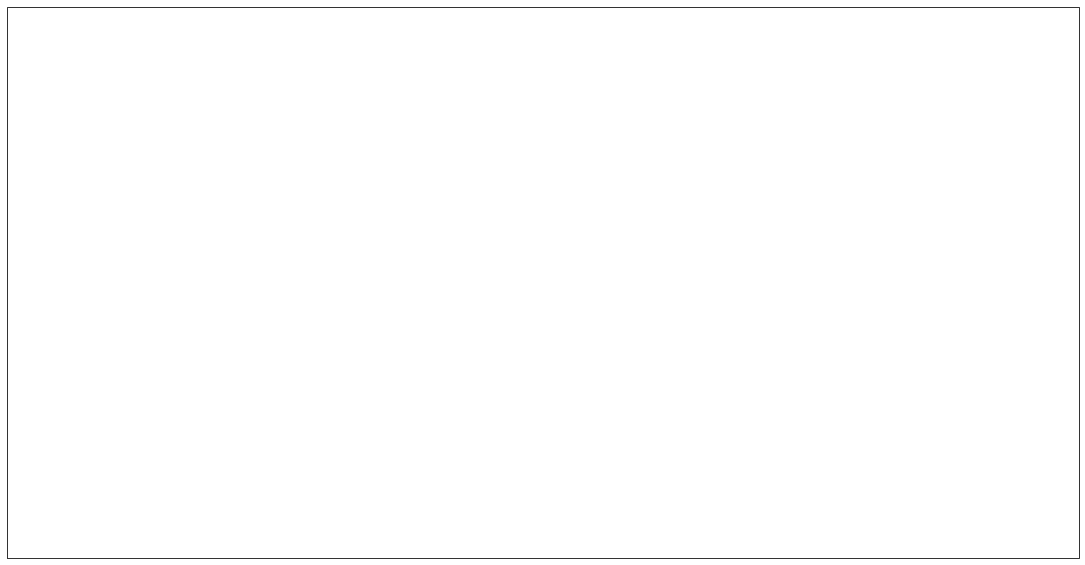

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(19.2, 10.8))
ax = plt.axes(projection=ccrs.Mercator(central_longitude=0,  
                                       min_latitude=-65,
                                       max_latitude=70))

In [17]:
ax.background_img(name='ne_shaded', resolution='low')
ax.set_extent([-170, 170, -65, 70], crs=ccrs.PlateCarree())

In [18]:
# https://neo.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG 1440 x 720

colors = {'Online': '#02b3e4', 'Offline': '#ecc81a'}

data_online = data.loc[data.Location == 'Online', :]
participants_counts = data_online.groupby(['lon', 'lat']).count()
    
# Get lists for longitudes and latitudes of graduates
index = list(participants_counts.index)
longs = [each[0] for each in index]
lats = [each[1] for each in index]
sizes = participants_counts['country']*0.5
    

ax.scatter(longs, lats,
           color=colors['Online'], alpha=0.8,  s=sizes, # blue
           transform=ccrs.PlateCarree())


data_offline = data.loc[data.Location != 'Online', :]
participants_counts = data_offline.groupby(['lon', 'lat']).count()
    
# Get lists for longitudes and latitudes of graduates
index = list(participants_counts.index)
longs = [each[0] for each in index]
lats = [each[1] for each in index]
sizes = participants_counts['country']*0.5
    

ax.scatter(longs, lats,
           color=colors['Offline'], alpha=0.4,  s=sizes, # yellow
           transform=ccrs.PlateCarree())

In [19]:
fontname = 'Open Sans'
fontsize = 28
# Positions for the date and grad counter
date = data.sample(1).loc[:, 'start_date_format'].iloc[0]
date_x = -27
date_y = -50
# Positions for the school labels
name_x = -70
name_y = -60      
name_spacing = {'Online': 0,
                'Offline': 3*48}
# Date text
ax.text(date_x, date_y, 
        f"{date.strftime('%b %d, %Y')}", 
        color='white',
        fontname=fontname, fontsize=fontsize*1.3,
        transform=ccrs.PlateCarree())

for status in ['Online', 'Offline']:
    ax.text(name_x + name_spacing[status], 
            name_y, 
            f"{status.upper()}: ", ha='center',
            fontname=fontname, fontsize=fontsize*1.1,
            color=colors[status],
            transform=ccrs.PlateCarree())
    
# Expands image to fill the figure and cut off margins
fig.tight_layout(pad=-0.5)

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


In [20]:
fig.savefig('to.png')

In [34]:
start_date = data.start_date_format.min()
end_date = data.start_date_format.max()

def create_map_day_img(day):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(19.2, 10.8))
    ax = plt.axes(projection=ccrs.Mercator(central_longitude=0,  
                                       min_latitude=-65,
                                       max_latitude=70))
    ax.background_img(name='ne_shaded', resolution='low')
    ax.set_extent([-170, 170, -65, 70], crs=ccrs.PlateCarree())
    
    date = start_date + timedelta(day)
    date_df = data[data['start_date_format'] <= date] 
    
    for status, alpha in [('Online', 0.8), ('Offline', 0.4)]:
        if status == 'Online':
            filt = date_df.Location == 'Online'
        if status == 'Offline':
            filt = date_df.Location != 'Online'
            
        df_status = date_df.loc[filt, :]
        participants_counts = df_status.groupby(['lon', 'lat']).count()
        
        index = list(participants_counts.index)
        longs = [each[0] for each in index]
        lats = [each[1] for each in index]
        sizes = participants_counts['country']*0.5

        ax.scatter(longs, lats,
                   color=colors[status], alpha=alpha,  s=sizes,
                   transform=ccrs.PlateCarree())
        
        ax.text(name_x + name_spacing[status], 
                    name_y, 
                    f"{status.upper()} participants: {int(participants_counts.sum()['country'])}", ha='center',
                    fontname=fontname, fontsize=fontsize*1.1,
                    color=colors[status],
                    transform=ccrs.PlateCarree())
        
    ax.text(date_x, date_y, 
        f"{date.strftime('%b %d, %Y')}", 
        color='white',
        fontname=fontname, fontsize=fontsize*1.3,
        transform=ccrs.PlateCarree())
        
    fig.tight_layout(pad=-0.5)
    fig.savefig(f"./frames/frame_{str(date.date())}.png", dpi=100, facecolor='black')
    plt.close(fig)

In [40]:


# for day in tqdm(range(100)): #range((end_date - start_date).days)
#     create_map_day_img(day)

number_of_days = (end_date - start_date).days
with Pool() as pool:
    with tqdm(total=number_of_days) as pbar:
        for _ in pool.imap(create_map_day_img, list(range(2617, number_of_days))):
            pbar.update()

 28%|██▊       | 1016/3633 [09:03<23:21,  1.87it/s] 


In [39]:
create_map_day_img
(pd.to_datetime('2019-01-04') - start_date).days

2617

Timestamp('2021-10-16 00:00:00')